<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/4_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Dataset import

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data = mf.feature_scaling(data)
data = mf.feature_engineering(data)
data = pd.get_dummies(data)
feature_names = mf.get_col(data)

# Model import

## XGBoost

In [5]:
categorical_features = np.arange(178,1091).tolist()

In [6]:
X_train = mf.get_set('train_id', data, 'xgboost_numpy')
X_val = mf.get_set('val_id', data, 'xgboost_numpy')
X_test = mf.get_set('test_id', data, 'xgboost_numpy')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Importante**: se il modello è trainato su GPU, quando si carica bisogna attivare il runtime con GPU, sennò il modello non vine caricato nel modo corretto. 

In [7]:
load = True
if load:
  from joblib import load
  from xgboost import XGBClassifier

  xgb = load("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost_numpy/xgb_np.joblib.dat")

Issue: https://github.com/slundberg/shap/issues/452

Vedere https://github.com/dmlc/xgboost/blob/master/demo/gpu_acceleration/shap.ipynb

In [8]:
# booster = xgb.get_booster()
# booster.predict(X_test.to_numpy(), pred_contribs = True, validate_features=False)

# SHAP

**Idea**

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Definition**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 

The Shapley value is NOT the difference in prediction when we would remove the feature from the model. 

**Interpretation**

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

**Theoretical algorithm**

Per determinare il valore di Shapley della feature x_j, si elimina la feature dal dataset, e delle altre si fanno tutte le possibili estrazioni, andando a fare la predizione solo con le feature selezionate e aggiungendo x_j. Facendo la differenza tra ogni predizione con e senza x_j si ottiene il contributo marginale di x_j. 
Per fare la predizione con il modello quando delle feature sono state eliminate, si rimpiazzano i loro valori con valori random (ovviamente tra quelli delle feature rimosse) estratti dal dataset. 


**Implementation**

SHAP turns the Shapley values method into an optimization problem and uses a special kernel function to measure proximity of data instances. The results of SHAP are sparse

**Riferimenti**

Repo github: https://github.com/slundberg/shap

Tutorial (vedere parte per RF): https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

Grafici con codice funzionante: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=classification



In [9]:
!pip install shap

     |████████████████████████████████| 327kB 11.1MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463907 sha256=03ede0ac11dc86ce1f25fa1f7597222b2c87af2aec6b6118a7f90239ebde044d
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [10]:
import shap
shap.initjs()
explainer = shap.KernelExplainer(xgb.predict_proba, shap.sample(X_test.to_numpy(), 100))

In [35]:
x = X_test.iloc[[0,1,20,56]].to_numpy()
kernel_shap = explainer.shap_values(x) #sono i valori di shapley
# kernel_shap[1].shape

In [36]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][0,:], feature_names=feature_names)

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][1,:], feature_names=feature_names)

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][2,:], feature_names=feature_names)

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][3,:], feature_names=feature_names)

In [30]:
# y = X_test.iloc[0:2].to_numpy()
# kernel_shap = explainer.shap_values(y) #sono i valori di shapley
# # kernel_shap[0].shape

In [42]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], kernel_shap[1][0,:], feature_names=feature_names)

In [43]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], kernel_shap[1][1,:], feature_names=feature_names)

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], kernel_shap[0], feature_names=feature_names)

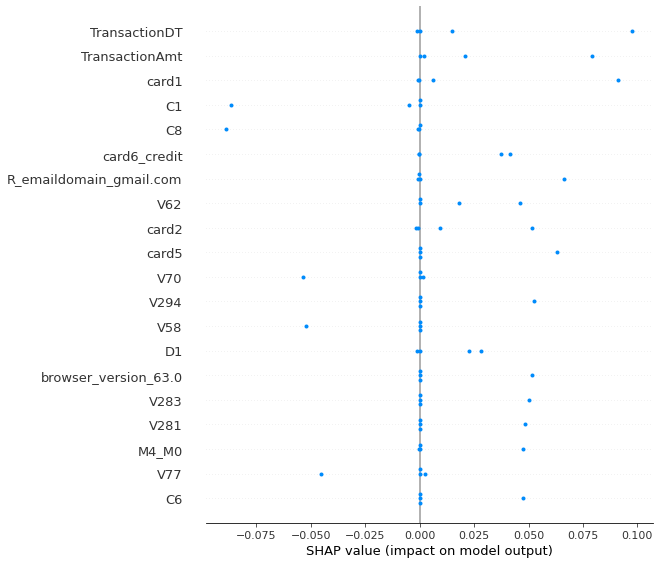

In [51]:
shap.summary_plot(kernel_shap[1], feature_names=feature_names)

Decision plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html?highlight=plot

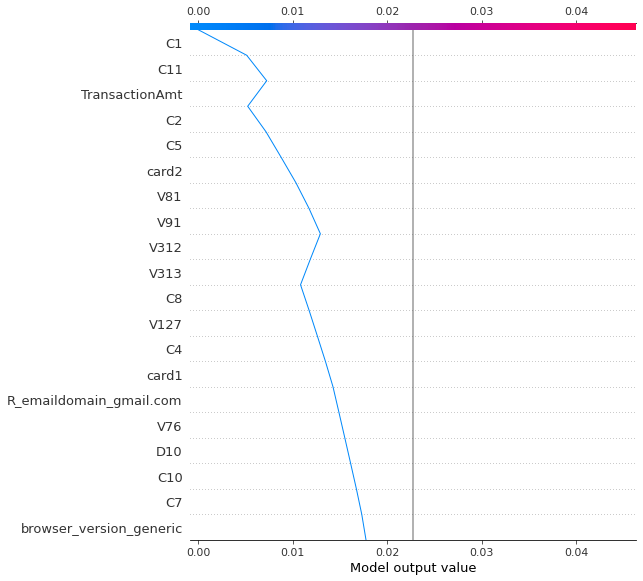

In [55]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][0,:], feature_names=feature_names)

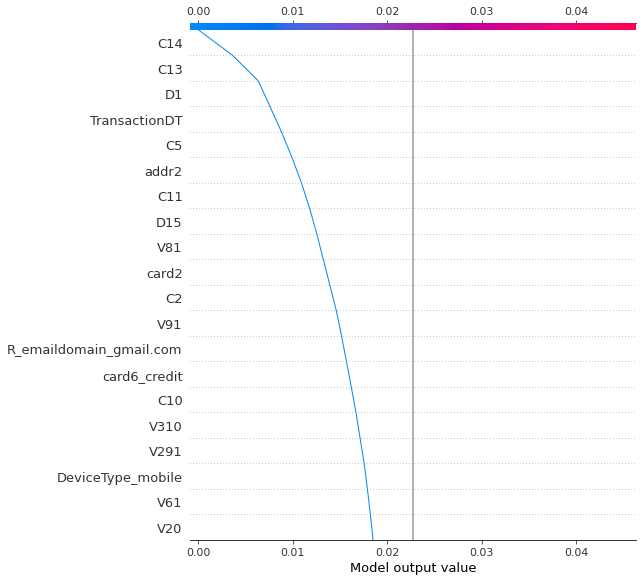

In [56]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][1,:], feature_names=feature_names)

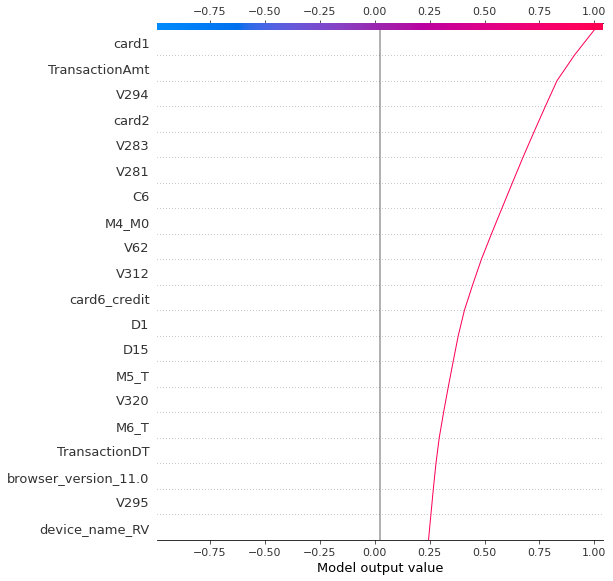

In [57]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][2,:], feature_names=feature_names)

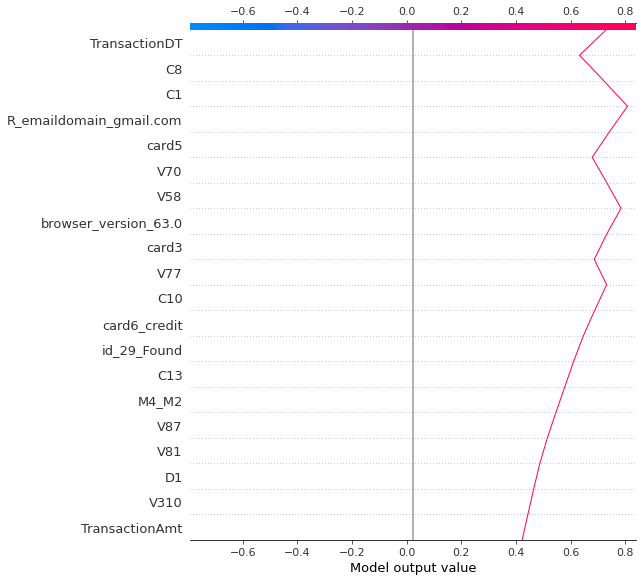

In [58]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][3,:], feature_names=feature_names)

Shap values con permutations. 

In [ ]:
# import shap
# explainer = shap.explainers.Permutation(xgb.predict_proba, shap.sample(X_test.to_numpy(), 100))
# shap_values = explainer(X_test.to_numpy()[:10])
# shap_values

Permutation explainer: 11it [22:34, 123.15s/it]
